<>:95: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1354051639.py:95: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(title='$\mathbf{Noise \quad Variance}$', fontsize=20,title_fontsize=20)


Variance= 1: Steady‐state error at t=250,000: 0.591122, avg over last 2,500 steps: 0.608629
Variance= 5: Steady‐state error at t=250,000: 2.296587, avg over last 2,500 steps: 2.354916
Variance=15: Steady‐state error at t=250,000: 6.952101, avg over last 2,500 steps: 7.278242


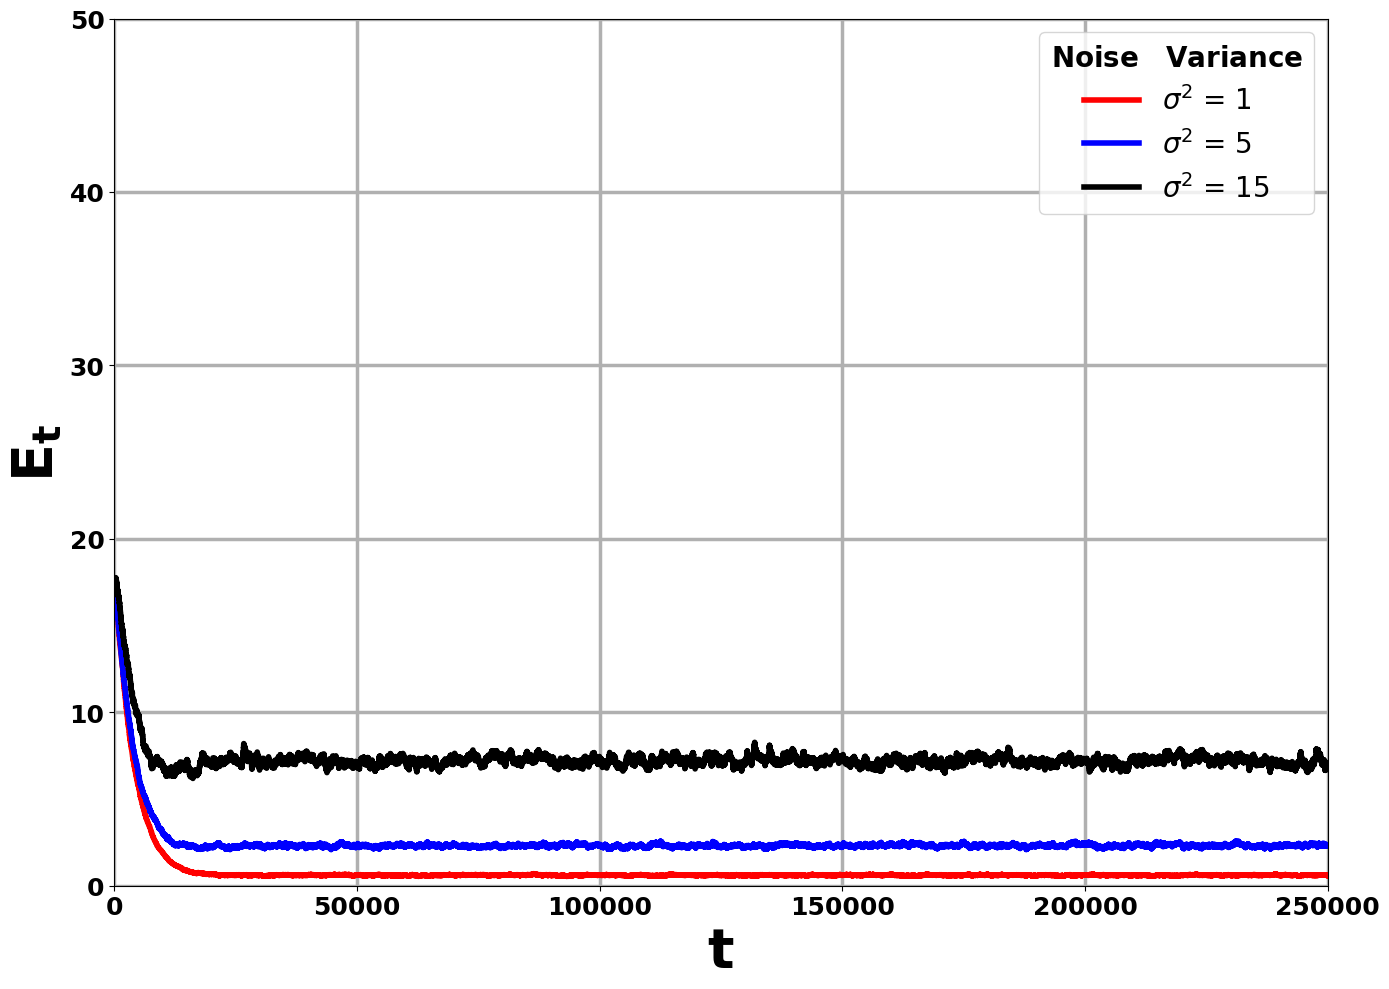

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data from npz
data = np.load('Qlearn_data_new.npz')
P     = data['P']         # shape: (S, S, A)
R     = data['R']         # shape: (S, A)
Qopt  = data['Qopt']      # optimal Q-function from value iteration
gamma = data['gamma'].item()
S     = data['S'].item()
A     = data['A'].item()

# Noise levels (treated as the std‑dev in the normal draw)
variance_list = [1, 5, 15]

# Hyperparameters
T     = 250000
G     = 20
alpha = 0.05

# Prepare storage
E_matrix           = np.zeros((len(variance_list), T))
steady_errors      = []
avg_final_errors   = []

for idx, var in enumerate(variance_list):
    E = np.zeros(T)

    for g in range(G):
        Q    = np.zeros((S, A))
        Qnew = np.zeros((S, A))
        Err  = np.zeros(T)
        s_t  = 0  # initial state

        for t in range(T):
            # copy last Q
            Q = Qnew.copy()

            # (i) Uniform random action
            a_t = np.random.randint(A)

            # (ii) Sample next state
            s_new = np.random.choice(S, p=P[s_t, :, a_t])

            # (iii) Q‑learning update with Gaussian noise
            noise = np.random.normal(0, var)
            Qnew = Q.copy()
            Qnew[s_t, a_t] = (
                (1 - alpha) * Q[s_t, a_t]
                + alpha * (R[s_t, a_t] + noise + gamma * np.max(Q[s_new, :]))
            )

            # track max‐norm error vs. Qopt
            Err[t] = np.max(np.abs(Qnew - Qopt))

            s_t = s_new

        E += Err

    # average over G runs
    E /= G
    E_matrix[idx, :] = E

    # compute steady‐state metrics
    final_err = E[-1]
    window    = int(0.01 * T)
    avg_err   = np.mean(E[-window:])

    steady_errors.append(final_err)
    avg_final_errors.append(avg_err)

    print(f"Variance={var:>2}: "
          f"Steady‐state error at t={T:,}: {final_err:.6f}, "
          f"avg over last {window:,} steps: {avg_err:.6f}")

# save all error traces in one .npy file
np.save('Vanilla_Q_error_data.npy', E_matrix)
colors = ['red', 'blue', 'black']
# Plotting
plt.figure(figsize=(14, 10))
for idx, var in enumerate(variance_list):
    plt.plot(
        E_matrix[idx],
        label=f'$σ^2$ = {var}',
        linewidth=4,
        color=colors[idx]
    )
plt.xlim([0, T])
plt.ylim([0, 50])
plt.grid(True,linewidth=2.5)
plt.xlabel(r'$\mathbf{t}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_t}$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(title='$\mathbf{Noise \quad Variance}$', fontsize=20,title_fontsize=20)
plt.tight_layout()
plt.show()
plt.savefig("vanilla_async_q_error_data.png", dpi=1200, bbox_inches="tight")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data
data = np.load('Qlearn_data_new.npz')
P     = data['P']         # shape: (S, S, A)
R     = data['R']         # shape: (S, A)
Qopt  = data['Qopt']      # optimal Q-function from value iteration
gamma = data['gamma'].item()
S     = data['S'].item()
A     = data['A'].item()

# Hyperparameters
T         = 250000
G         = 20
alpha     = 0.1
epsilons  = [0.001,0.005,0.01]  # corruption probabilities
window    = int(0.01 * T)                # last 1% window size

# Define adversary: outputs a fixed large negative reward
def adversary_fn():
    return -10000.0

# Pre-allocate
error_matrix      = np.zeros((len(epsilons), T))
steady_errors     = []
avg_final_errors  = []

for idx, eps in enumerate(epsilons):
    E = np.zeros(T)

    for g in range(G):
        Q    = np.zeros((S, A))
        Qnew = np.zeros((S, A))
        Err  = np.zeros(T)
        s_t  = 0  # initial state

        for t in range(T):
            Q = Qnew.copy()

            # Uniform random action
            a_t = np.random.randint(A)

            # State transition
            s_new = np.random.choice(S, p=P[s_t, :, a_t])

            # Possibly corrupt the reward
            if np.random.rand() < eps:
                reward = adversary_fn()
            else:
                reward = R[s_t, a_t]

            # Q‑learning update
            Qnew[s_t, a_t] = (
                (1 - alpha) * Q[s_t, a_t]
                + alpha * (reward + np.random.normal(0, 15) + gamma * np.max(Q[s_new, :]))
            )

            # Track error
            Err[t] = np.max(np.abs(Qnew - Qopt))
            s_t = s_new

        E += Err

    # average over G runs
    E /= G
    error_matrix[idx] = E

    # compute and print steady-state metrics
    final_err = E[-1]
    avg_err   = np.mean(E[-window:])
    steady_errors.append(final_err)
    avg_final_errors.append(avg_err)

    print(f"ε = {eps:<5}: "
          f"Steady‑state error @ t={T}: {final_err:.6f}, "
          f"Mean over last {window:,} steps: {avg_err:.6f}")

# Save the error traces for all ε in one array
np.save('Vanilla_Q_error_data_corruption_var_15.npy', error_matrix)

ε = 0.001: Steady‑state error @ t=250000: 520.410470, Mean over last 2,500 steps: 560.164560
ε = 0.005: Steady‑state error @ t=250000: 876.167346, Mean over last 2,500 steps: 913.642357
ε = 0.01 : Steady‑state error @ t=250000: 1100.359086, Mean over last 2,500 steps: 1143.471935


<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3477127494.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(title='$\mathbf{Corruption \quad Probability}$', fontsize=20,title_fontsize=20, loc='lower right')


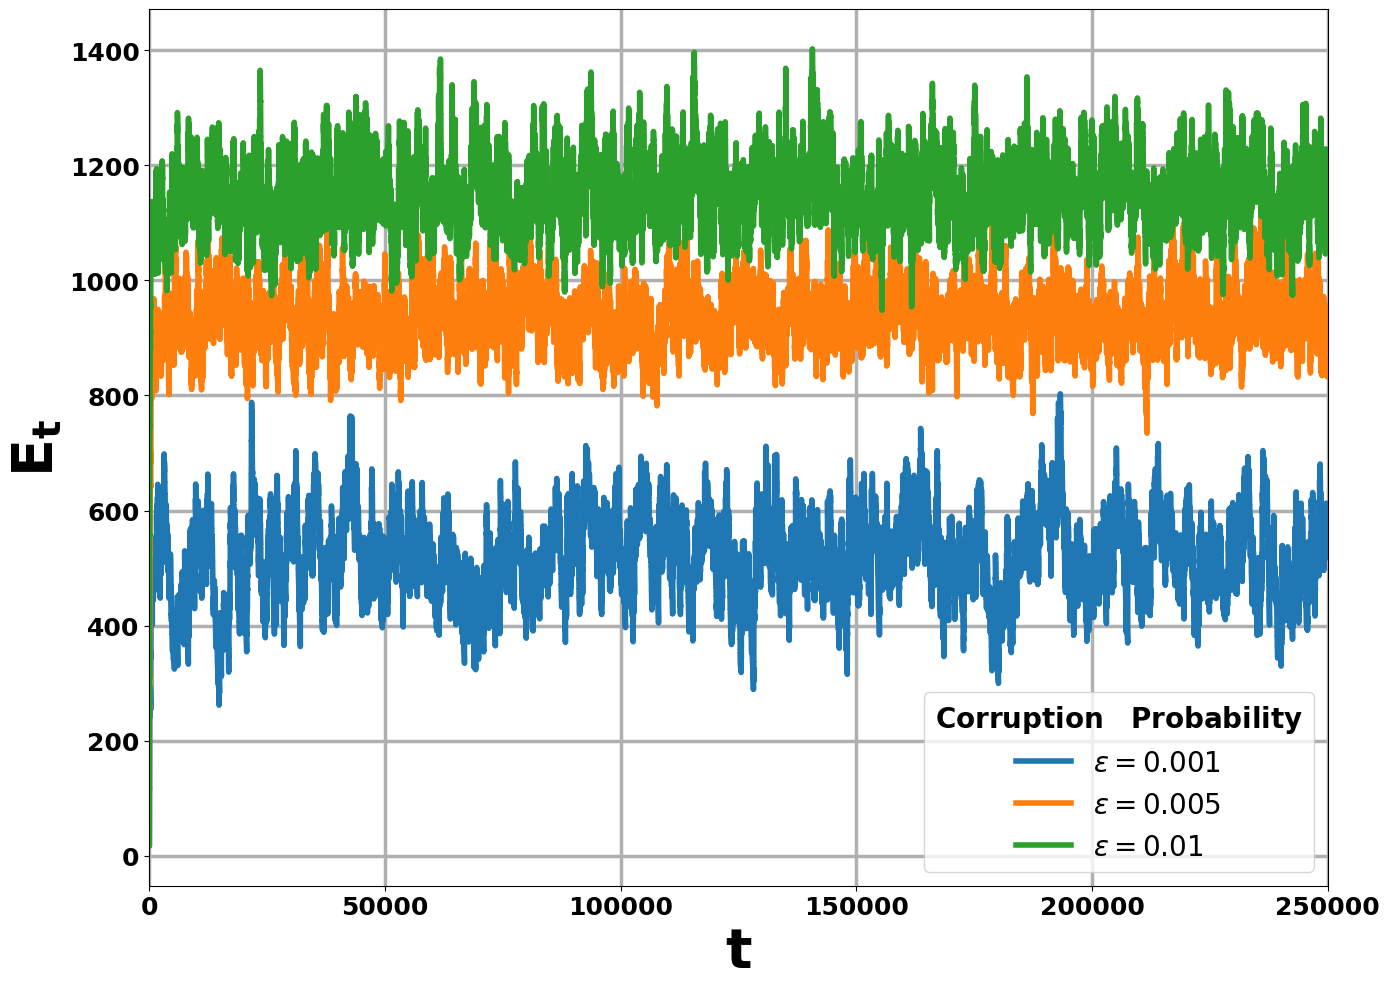

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the saved error matrix:
#    shape = (n_curves, T)
r_error_matrix = np.load('Vanilla_Q_error_data_corruption_var_15.npy')

# 2) Re‑define your x‑axis length and labels:
n_curves, T = r_error_matrix.shape
epsilons = [0.001,0.005,0.01]   # must match the order you used when saving

# 3) Plot each row as one curve
plt.figure(figsize=(14, 10))
for idx, eps in enumerate(epsilons):
    plt.plot(
        r_error_matrix[idx],
        label=fr'$\epsilon={eps}$',
        linewidth=4
    )

plt.xlim([0, T])
plt.xlabel(r'$\mathbf{t}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_t}$', fontsize=40, fontweight='bold')
plt.legend(title='$\mathbf{Corruption \quad Probability}$', fontsize=20,title_fontsize=20, loc='lower right')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True, linewidth=2.5)
plt.tight_layout()
plt.show()
# Save as high-resolution image
plt.savefig("Vanilla_Q_error_data_corruption_var_15", dpi=1200, bbox_inches="tight")

plt.show()

In [ ]:
def generate_reward(true_reward, corruption_prob, noise_var, corrupt_value=-100000.0):
    """
    Returns the observed reward:
    - with probability `corruption_prob`, returns a corrupted reward (e.g., a large negative spike),
    - otherwise returns the true reward with Gaussian noise added.
    """
    if np.random.rand() < corruption_prob:
        return corrupt_value
    else:
        return true_reward + np.random.normal(0, noise_var)


<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2385299326.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(title='$\mathbf{Robust \quad Async-Q}$', fontsize=20,title_fontsize=20)


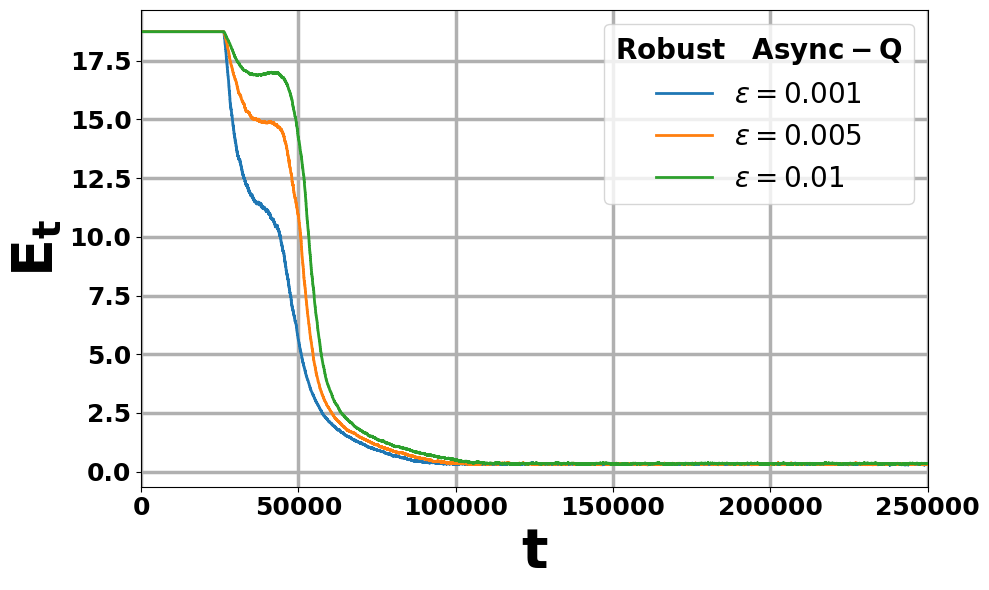

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the saved error matrix:
#    shape = (n_curves, T)
robust_error_matrix = np.load('Robust_Q_error_data_variance_1_MDP_20x5_T_250000.npy')

# 2) Re-define your x-axis length and labels:
n_curves, T = robust_error_matrix.shape
epsilons = [0.001,0.005,0.01]   # must match the order you used when saving

# 3) Plot each row as one curve
plt.figure(figsize=(10, 6))
for idx, eps in enumerate(epsilons):
    plt.plot(
        robust_error_matrix[idx],
        label=fr'$\epsilon={eps}$',
        linewidth=2
    )

plt.xlim([0, T])
plt.xlabel(r'$\mathbf{t}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_t}$', fontsize=40, fontweight='bold')
plt.legend(title='$\mathbf{Robust \quad Async-Q}$', fontsize=20,title_fontsize=20)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True,linewidth=2.5)
plt.tight_layout()

# Save as high-resolution image
plt.savefig("robust_async_q_error_plot.png", dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------- Trimmed Mean Estimator -------------------------

def trimmed_mean_estimator(data, epsilon, delta):
    M = len(data)
    if M < 2:
        return np.mean(data) if M > 0 else 0.0
    if M % 2 != 0:
        data = data[:-1]
        M -= 1

    np.random.shuffle(data)
    D1, D2 = np.split(data, 2)
    D1_sorted = np.sort(D1)
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M

    lower_idx = int(np.floor(zeta * len(D1_sorted)))
    upper_idx = int(np.floor((1 - zeta) * len(D1_sorted)) - 1)
    lower_idx = max(0, min(lower_idx, len(D1_sorted) - 1))
    upper_idx = max(0, min(upper_idx, len(D1_sorted) - 1))

    alpha_clip = D1_sorted[lower_idx]
    beta_clip  = D1_sorted[upper_idx]
    phi        = lambda x: np.clip(x, alpha_clip, beta_clip)
    trimmed    = phi(D2)

    return (2 / M) * np.sum(trimmed)

# ----------------------------- Load Data --------------------------------------

data   = np.load('Qlearn_data_new.npz')
P      = data['P']         # (S, S, A)
R      = data['R']         # (S, A)
Qopt   = data['Qopt']      # optimal Q
gamma  = data['gamma'].item()
S      = data['S'].item()
A      = data['A'].item()
p      = data['p']
p_hat  = np.min(p)

# ----------------------------- Hyperparameters -------------------------------

T            = 250000
G            = 20
delta        = 0.1
C            = 1.1
alpha        = 0.1
epsilons     = [0.001,0.005,0.01]
ra_mod_delta = delta / (4 * T)
window       = int(0.01 * T)  # last 1%
noise_var    = 5.0
# ----------------------------- Helper for threshold --------------------------

def G_t(t, eps):
    T_lim = (104/3 * p_hat) * np.log((800*T) / ra_mod_delta) + 1
    if t <= T_lim:
        return 0.0
    term = np.sqrt((4*np.log(8 / ra_mod_delta)) / (3*p_hat*t)) + np.sqrt(eps)
    return  C * max(np.max(R),np.sqrt(noise_var)) * term + max(np.max(R),np.sqrt(noise_var))

# ----------------------------- Run & Collect Errors --------------------------

errs_by_eps   = {}
error_matrix  = np.zeros((len(epsilons), T))

for idx, eps in enumerate(epsilons):
    E_total = np.zeros(T)

    for _ in range(G):
        Q    = np.zeros((S, A))
        Err  = np.zeros(T)
        s_t  = 0
        D    = defaultdict(list)

        for t in range(T):
            # (i) action, (ii) transition
            a_t  = np.random.randint(A)
            s_tp1 = np.random.choice(S, p=P[s_t, :, a_t])

            # (iii) possibly adversarial reward
            y_t = generate_reward(R[s_t, a_t], corruption_prob=eps, noise_var=5.0)

            # (iv) collect, (v) trimmed mean, (vi) threshold
            D[(s_t, a_t)].append(y_t)
            r_bar = trimmed_mean_estimator(np.array(D[(s_t, a_t)]), eps, ra_mod_delta)
            r_tilde = 0.0 if abs(r_bar) > G_t(t, eps) else r_bar

            # (vii) Q‑update
            Q[s_t, a_t] = (1 - alpha) * Q[s_t, a_t] + alpha * (
                             r_tilde + gamma * np.max(Q[s_tp1])
                          )

            # (viii) error
            Err[t] = np.max(np.abs(Q - Qopt))
            s_t = s_tp1

        E_total += Err

    # average over G runs
    E = E_total / G
    errs_by_eps[eps]      = E
    error_matrix[idx, :]  = E

    # steady‑state metrics
    final_err = E[-1]
    avg_err   = np.mean(E[-window:])
    print(f"ε = {eps:<6}: "
          f"E_T = {final_err:.6f}, "
          f"mean over last {window:,} steps = {avg_err:.6f}")

# ----------------------------- Save Error Data -------------------------------

np.save('Robust_Q_error_data_variance_5.npy', error_matrix)
print("\nAll error traces saved to 'error_data_trimmed.npy' "
      "(shape = [len(epsilons), T])")


ε = 0.001 : E_T = 0.627340, mean over last 2,500 steps = 0.646626
ε = 0.005 : E_T = 0.704726, mean over last 2,500 steps = 0.724211
ε = 0.01  : E_T = 0.707907, mean over last 2,500 steps = 0.747724

All error traces saved to 'error_data_trimmed.npy' (shape = [len(epsilons), T])


<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1373926509.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(title='$\mathbf{Robust \quad Async-Q}$', fontsize=20,title_fontsize=20)


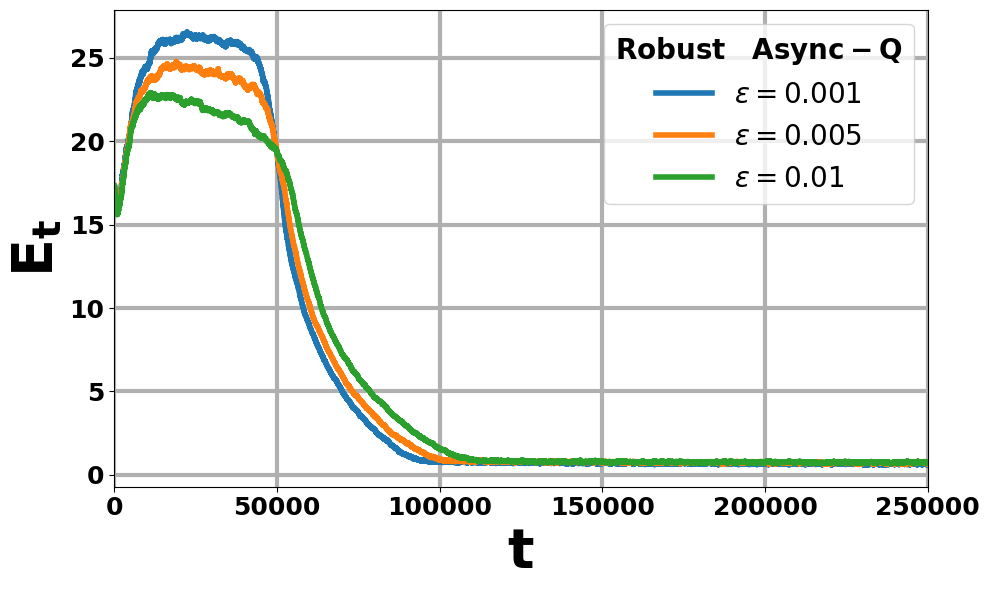

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the saved error matrix:
#    shape = (n_curves, T)
robust_error_matrix = np.load('Robust_Q_error_data_variance_5.npy')

# 2) Re-define your x-axis length and labels:
n_curves, T = robust_error_matrix.shape
epsilons = [0.001,0.005,0.01]   # must match the order you used when saving

# 3) Plot each row as one curve
plt.figure(figsize=(10, 6))
for idx, eps in enumerate(epsilons):
    plt.plot(
        robust_error_matrix[idx],
        label=fr'$\epsilon={eps}$',
        linewidth=4
    )

plt.xlim([0, T])
plt.xlabel(r'$\mathbf{t}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_t}$', fontsize=40, fontweight='bold')
plt.legend(title='$\mathbf{Robust \quad Async-Q}$', fontsize=20,title_fontsize=20)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True,linewidth=3)
plt.tight_layout()

# Save as high-resolution image
plt.savefig("robust_async_q_error_plot_var_5.png", dpi=1200, bbox_inches="tight")

plt.show()